In [ ]:
#| eval: false
! [ -e /content ] && pip install -Uqq xcube # upgrade xcube on colab

In [ ]:
from xcube.l2r.all import *

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

Make sure we have that "beast":

In [ ]:
ic(torch.cuda.get_device_name(default_device()));
test_eq(torch.cuda.get_device_name(0), torch.cuda.get_device_name(default_device()))
test_eq(default_device(), torch.device(0))
print(f"GPU memory = {torch.cuda.get_device_properties(default_device()).total_memory/1024**3}GB")

ic| torch.cuda.get_device_name(default_device()): 'Quadro RTX 8000'


GPU memory = 44.99969482421875GB


Setting some environment variables:

In [ ]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

Setting defaults for pandas and matplotlib:

In [ ]:
# Set the default figure size
plt.rcParams["figure.figsize"] = (6, 4)

# L2R Training

> Training a learning-to-rank model

In this tutorial we will train a l2r model. We will bootstrap the model using the data we prepared in tutorial [booting L2R](14_tutorial.boot_l2r.ipynb)

## Getting ready

Prepping l2r data for xcube's `L2RDataLoader`

In [ ]:
source = untar_xxx(XURLs.MIMIC3_L2R)
source.ls()

(#11) [Path('/home/deb/.xcube/data/mimic3_l2r/info.pkl'),Path('/home/deb/.xcube/data/mimic3_l2r/code_descriptions.csv'),Path('/home/deb/.xcube/data/mimic3_l2r/mimic3-9k_tok_lbl_info.pkl'),Path('/home/deb/.xcube/data/mimic3_l2r/code_desc.pkl'),Path('/home/deb/.xcube/data/mimic3_l2r/p_TL.pkl'),Path('/home/deb/.xcube/data/mimic3_l2r/trn_val_split.pkl'),Path('/home/deb/.xcube/data/mimic3_l2r/mimic3-9k_tok.ft'),Path('/home/deb/.xcube/data/mimic3_l2r/mimic3-9k_lbl.ft'),Path('/home/deb/.xcube/data/mimic3_l2r/mimic3-9k.csv'),Path('/home/deb/.xcube/data/mimic3_l2r/scored_tokens.pth')...]

Note: If you don't have enough GPU/CPU memory just run the last cell of this section to load the pregenerated ones.

Here we can just load the file which contains the relevant information about the tokens, labels and their mutual-information-gain:

In [ ]:
# Cheking if you have enough memory to set device
cuda_memory = torch.cuda.get_device_properties(torch.cuda.current_device()).total_memory/1024**3
if cuda_memory < 10.: print(f"Not Enough GPU Memory (just {cuda_memory} GB), we'll use {default_device(use=False)}")
l2r_bootstrap = torch.load(source/'mimic3-9k_tok_lbl_info.pkl', map_location=default_device())

In [ ]:
test_eq(l2r_bootstrap.keys(), ['toks', 'lbs', 'mut_info_lbl_entropy', 'mutual_info_jaccard'])
toks = l2r_bootstrap.get('toks', None)
lbs = l2r_bootstrap.get('lbs', None)
info = l2r_bootstrap.get('mutual_info_jaccard', None)
for o in (toks, lbs, info): assert o is not None
test_eq(info.shape, (len(toks), len(lbs)))

`info` contains the mutual-information-gain values for the tokens and labels. In what follows we'll toss in some pandas to take a good hard look at the data before we proceed towards making xcube's `L2RDataLoader`: 

*Note:* Storing the tokens and the labels in a dataframe as `object` will take up a lot of RAM space when we prepare that `DataLoader`. So we are going to store the corresponding token and label indices instead in a dataframe called `df_l2r`. We are also going to store the tokens and the labels with their corresponding indices in seperate dataframes (this will help in quick merging for analysis).

Here we will rank the tokens for each label based on the decreasing values of the mutual-info and stack them up with mutual-info.

In [ ]:
ranked = info.argsort(descending=True, dim=0).argsort(dim=0)
info_ranked =torch.stack((info, ranked), dim=2).flatten(start_dim=1)

In [ ]:
cols = pd.MultiIndex.from_product([range(len(lbs)), ['mutual_info', 'rank']], names=['label', 'key2'])
df_l2r = pd.DataFrame(info_ranked, index=range(len(toks)), columns=cols)
df_l2r.index.name='token'

In [ ]:
df_l2r.head(3)

label        0                    1                    2              \
key2  mutual_info     rank mutual_info     rank mutual_info     rank   
token                                                                  
0        0.000022    866.0    0.000011   1022.0    0.000022   1156.0   
1        0.000000  56854.0    0.000000  41418.0    0.000000  56853.0   
2        0.000000  56855.0    0.000000  41419.0    0.000000  56854.0   

label        3                    4              ...        8917           \
key2  mutual_info     rank mutual_info     rank  ... mutual_info     rank   
token                                            ...                        
0        0.000011    823.0    0.000033    984.0  ...    0.000011    850.0   
1        0.000000  41410.0    0.000000  22836.0  ...    0.000000  41421.0   
2        0.000000  41411.0    0.000000  22837.0  ...    0.000000  41422.0   

label        8918                 8919                 8920           \
key2  mutual_info     rank mutual_info     rank mutual_info     rank   
token                                                                  
0        0.000033    944.0    0.000011    960.0    0.000011    771.0   
1        0.000000  22861.0    0.000000  41423.0    0.000000  41412.0   
2        0.000000  22862.0    0.000000  41424.0    0.000000  41413.0   

label          8921           
key2    mutual_info     rank  
token                         
0      6.888287e-07  31821.0  
1      0.000000e+00  32385.0  
2      0.000000e+00  32386.0  

[3 rows x 17844 columns]

In [ ]:
df_l2r = df_l2r.stack(level=0).reset_index().rename_axis(None, axis=1)
# the above pandas trick can be simulated using numpy as follows
# n = df_l2r.to_numpy()
# n_toks, n_lbs = len(df_l2r.index), len(df_l2r.columns.levels[0])
# n = n.reshape(-1, 2)
# tok_lbs_idxs = np.mgrid[slice(0,n_toks), slice(0,n_lbs)].reshape(2,-1).T
# n = np.concatenate((tok_lbs_idxs,n), axis=-1)
# df_l2r = pd.DataFrame(n, columns=['token', 'label', 'mutual_info', 'rank'])
df_l2r[['token', 'label']] = df_l2r[['token', 'label']].astype(np.int32) 
test_eq(len(df_l2r), len(toks) * len(lbs))

In [ ]:
df_l2r.head(3)

,token,label,mutual_info,rank
0,0,0,0.000022,866.0
1,0,1,0.000011,1022.0
2,0,2,0.000022,1156.0


In [ ]:
df_l2r.memory_usage()/1024**3

Index          1.192093e-07
token          1.906211e+00
label          1.906211e+00
mutual_info    1.906211e+00
rank           1.906211e+00
dtype: float64

In [ ]:
df_toks = pd.DataFrame([(i, w) for i,w in enumerate(toks)], columns=['token', 'tok_val'])
df_lbs = pd.DataFrame([(i,w) for i, w in enumerate(lbs)], columns=['lbl', 'lbl_val'])

In [ ]:
df_toks.head(3)

,token,tok_val
0,0,xxunk
1,1,xxpad
2,2,xxbos


In [ ]:
df_lbs.head(3)

,lbl,lbl_val
0,0,003.0
1,1,003.1
2,2,003.8


You can save `df_l2r`, `df_toks` and `df_lbs` if you are working on your own dataset. In this case though `untar_xxx` has already downloaded those for you.

In [ ]:
L(source.glob("**/*.ft"))

(#3) [Path('/home/deb/.xcube/data/mimic3_l2r/mimic3-9k_tok.ft'),Path('/home/deb/.xcube/data/mimic3_l2r/mimic3-9k_lbl.ft'),Path('/home/deb/.xcube/data/mimic3_l2r/mimic3-9k_tok_lbl.ft')]

## Statistical Analysis

In [ ]:
#| eval: false
df_l2r = pd.read_feather(source/'mimic3-9k_tok_lbl.ft')
test_eq(df_l2r.dtypes.mutual_info, np.float32)

In [ ]:
df_l2r.head(3)

,token,label,mutual_info,rank
0,0,0,0.000022,866.0
1,0,1,0.000011,1022.0
2,0,2,0.000022,1156.0


If you loaded the pregenerated `df_l2r` then you will see the column "bcx_mutual_info". It is a box-cox transformation of the "mutual-info". In this section we'll justify that transformation. So let's perform some statistical analysis of that `mutual_info` column before we build the `L2RDataLoader` in the next section.

In [ ]:
# import gc; gc.collect()
# df_l2r.info()
# ic(df_l2r.memory_usage().sum()/1024**3)
# ic(sys.getsizeof(df_l2r)/1024**3);
# df_collab.token.nunique()

In [ ]:
mut_infos = df_l2r['mutual_info'].to_numpy()

In [ ]:
mut_infos.min(), mut_infos.max(), mut_infos.mean()

(-6.852321e-05, 0.99999636, 7.175153e-05)

In [ ]:
%%time
skew(mut_infos)

CPU times: user 2.22 s, sys: 1.14 s, total: 3.36 s
Wall time: 3.36 s


142.75660007849734

The mutual-info values are incredibly skewed. So we need to apply some transformation. Sometimes `mut_infos` might contain negs, we need to convert those to eps.

In [ ]:
# np.where(mut_infos<0, 1, 0).sum() # or, better yet
where_negs = mut_infos < 0
ic(np.sum(where_negs))
eps = np.float32(1e-20)
mut_infos[where_negs] = eps
test_eq(np.sum(mut_infos<0), 0)
ic(np.min(mut_infos), np.max(mut_infos), np.mean(mut_infos));

ic| np.sum(where_negs): 111226814
ic| np.min(mut_infos): 0.0
    np.max(mut_infos): 0.99999636
    np.mean(mut_infos): 7.697003e-05


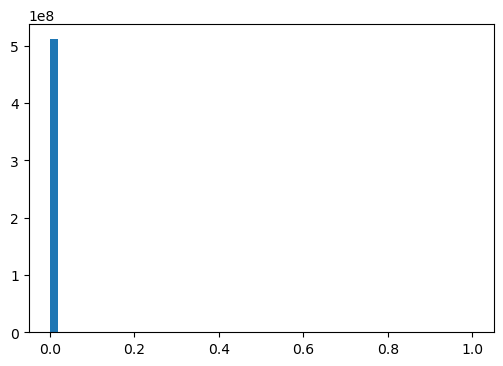

In [ ]:
hist, bins, _ = plt.hist(mut_infos, bins=50)
# plt.yscale('log')

**Applying log transform:**

In [ ]:
log_mut_infos = np.log(mut_infos + eps)

In [ ]:
np.isnan(log_mut_infos).sum(), np.isneginf(log_mut_infos).sum(), np.isinf(log_mut_infos).sum()

(0, 0, 0)

In [ ]:
%time skew(log_mut_infos)

CPU times: user 2.35 s, sys: 959 ms, total: 3.31 s
Wall time: 3.3 s


-1.3383214188674972

A little better skewness than before!

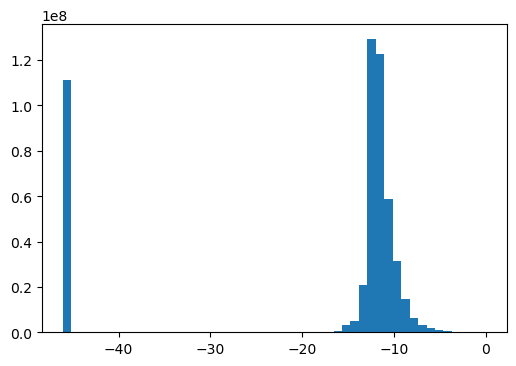

In [ ]:
hist, bins, _ = plt.hist(log_mut_infos, bins=50,)

**Applying sqrt transform:**

In [ ]:
sqrt_mut_infos = np.sqrt(mut_infos)

In [ ]:
np.isnan(sqrt_mut_infos).sum(), np.isinf(sqrt_mut_infos).sum(), np.isneginf(sqrt_mut_infos).sum()

(0, 0, 0)

In [ ]:
%time skew(sqrt_mut_infos)

CPU times: user 2.38 s, sys: 1.25 s, total: 3.63 s
Wall time: 3.63 s


16.40865608826817

Worse than log transform!

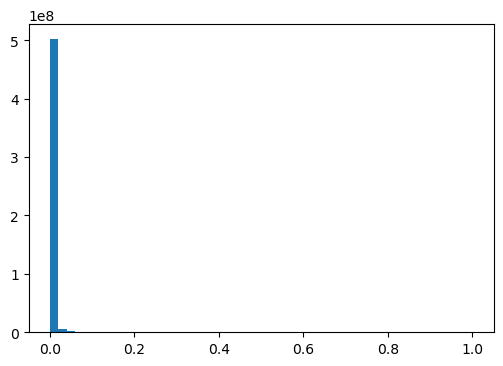

In [ ]:
hist, bins, _ = plt.hist(sqrt_mut_infos, bins=50)

**Apply box-cox transfrom:**

In [ ]:
bcx_mut_infos, *_ = boxcox(mut_infos+eps)

/home/deb/miniconda3/envs/deep/lib/python3.10/site-packages/scipy/stats/_morestats.py:933: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/deb/miniconda3/envs/deep/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [ ]:
np.isnan(bcx_mut_infos).sum(), np.isinf(bcx_mut_infos).sum(), np.isneginf(bcx_mut_infos).sum()

(0, 0, 0)

In [ ]:
%time skew(bcx_mut_infos)

CPU times: user 2.45 s, sys: 1.04 s, total: 3.49 s
Wall time: 3.49 s


-0.885981418331696

This is the best skew so we'll go with boxcox.

In [ ]:
df_l2r['bcx_mutual_info'] = bcx_mut_infos

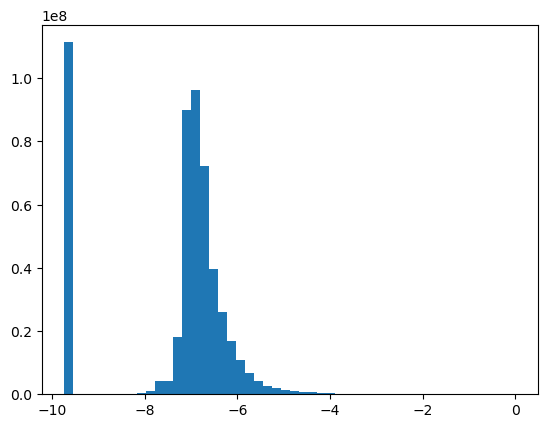

In [ ]:
#| eval: false
hist, bins, _ = plt.hist(bcx_mut_infos, bins=50)

In [ ]:
#| eval: false
np.min(bcx_mut_infos), np.max(bcx_mut_infos), np.mean(bcx_mut_infos), np.median(bcx_mut_infos)

(-9.734209, -3.6358892e-06, -7.381837, -6.9605794)

In [ ]:
# from IPython.display import clear_output

# clear_output(wait=True)

# from tqdm import tqdm
# from time import sleep
# import psutil

# with tqdm(total=100, desc='cpu%', position=1) as cpubar, tqdm(total=100, desc='ram%', position=0) as rambar:
#     while True:
#         rambar.n=psutil.virtual_memory().percent
#         cpubar.n=psutil.cpu_percent()
#         rambar.refresh()
#         cpubar.refresh()
#         sleep(0.5)
#         clear_output(wait=True)

Box plots using matplotlib

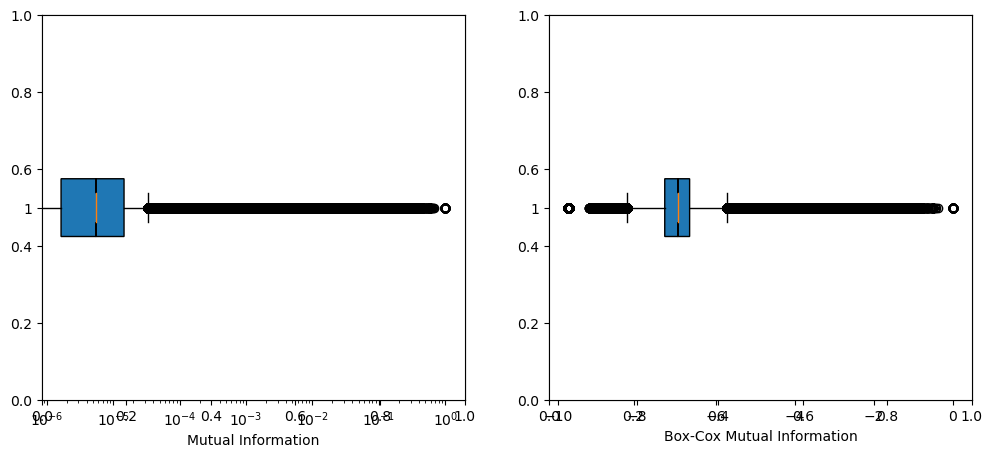

CPU times: user 1min 35s, sys: 9.16 s, total: 1min 44s
Wall time: 1min 44s


In [ ]:
#| eval: false
%%time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.boxplot(mut_infos, vert=0, notch=True, patch_artist=True)
ax1.set_xscale('log')
ax1.set_xlabel('Mutual Information')

ax2.boxplot(bcx_mut_infos, vert=0, notch=True, patch_artist=True)
# ax2.set_xscale('symlog')
ax2.set_xlabel('Box-Cox Mutual Information')

plt.show()

Histograms and kde using matplotlib:

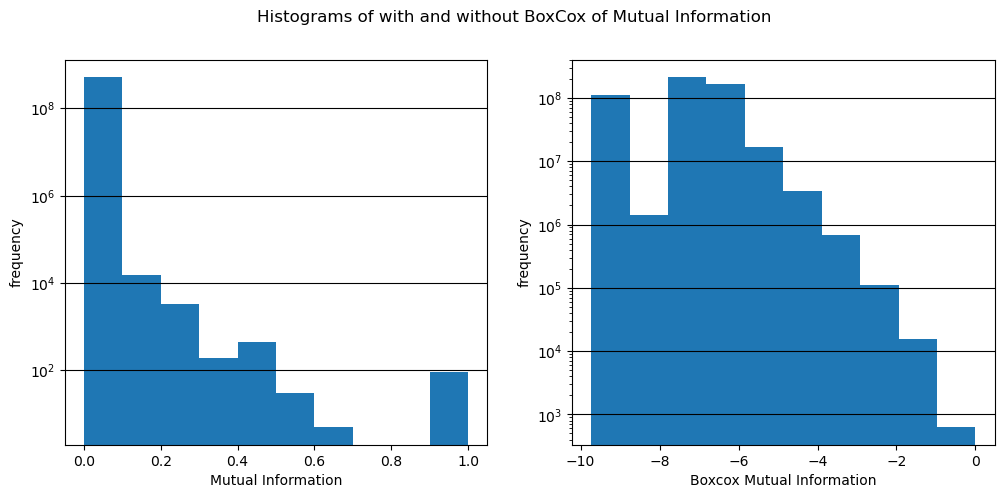

In [ ]:
#| eval: false
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# hist, bins, pathches = ax1.hist(df_l2r['mutual_info'])
hist, bins, pathches = ax1.hist(mut_infos)
ax1.set_xlabel('Mutual Information')
ax1.set_ylabel('frequency')
ax1.grid(axis='y', color='black')
ax1.set_yscale('log')

# ax2.hist(df_l2r['bcx_mutual_info'])
ax2.hist(bcx_mut_infos)
ax2.set_xlabel('Boxcox Mutual Information')
ax2.set_ylabel('frequency')
ax2.grid(axis='y', color='black')
ax2.set_yscale('log')

fig.suptitle('Histograms of with and without BoxCox of Mutual Information')
plt.show()

In [ ]:
#| eval:false
bdrs = [bins[i:i+2] for i in range(0, len(bins)-1)]
pd.DataFrame({'mut_infos bdrs': bdrs, 'counts': hist})

,mut_infos bdrs,counts
0,"[0.0, 0.09999963641166687]",511675599.0
1,"[0.09999963641166687, 0.19999927282333374]",14848.0
2,"[0.19999927282333374, 0.2999989092350006]",3323.0
3,"[0.2999989092350006, 0.3999985456466675]",191.0
4,"[0.3999985456466675, 0.49999818205833435]",454.0
5,"[0.49999818205833435, 0.5999978184700012]",30.0
6,"[0.5999978184700012, 0.6999974250793457]",5.0
7,"[0.6999974250793457, 0.799997091293335]",0.0
8,"[0.799997091293335, 0.8999967575073242]",0.0
9,"[0.8999967575073242, 0.9999963641166687]",94.0


In [ ]:
# from scipy.stats import gaussian_kde
# density = gaussian_kde(df_l2r['mutual_info'])
# xs = np.linspace(0, 1, 200)
# density.covariance_factor = lambda : .25
# density._compute_covariance()
# plt.plot(xs, density(xs))
# plt.show()

We can now build the `Dataloaders` object from this dataframe `df_collab`, by defaultit takes the first column as the user (in our case the token) and the second column as the item (in our case the label), and the third column as the ratings (in our case the frequency):

## Build `L2RDataloader` 

In this section we'll build `L2RDataLoader` for [Learning to Rank (L2R)](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/MSR-TR-2010-82.pdf)

In [ ]:
#| eval: false
df_l2r = pd.read_feather(source/'mimic3-9k_tok_lbl.ft')

In [ ]:
df_l2r = df_l2r.drop(['mutual_info', 'bcx_mutual_info'], axis=1)
df_l2r.token.nunique(), df_l2r.label.nunique()
df_l2r.head(3)

,token,label,rank
0,0,0,866.0
1,0,1,1022.0
2,0,2,1156.0


**`df_tiny`**: If we need a smaller dataset for quick iterations

Note: For technical reasons behind building a `L2RDataloader` the number of tokens should be $x (mod 64) \equiv 8$.

In [ ]:
num_toks, num_lbs = 8 + 5*64, 104

In [ ]:
# might have to repeat this a few times until the cell asserst true
np.random.seed(101)
rnd_toks = np.random.randint(0, len(df_l2r.token.unique()), size=(num_toks,) )
np.random.seed(101)
rnd_lbs = np.random.randint(0, len(df_l2r.label.unique()), size=(num_lbs,) )
mask = df_l2r.token.isin(rnd_toks) & df_l2r.label.isin(rnd_lbs)
df_tiny = df_l2r[mask].reset_index(drop=True)
test_eq(df_tiny.token.nunique(), num_toks) 
test_eq(df_tiny.label.nunique(), num_lbs) 
# df_tiny.apply(lambda x: x.nunique())

In [ ]:
df_tiny.head()

,token,label,rank
0,22,49,1877.0
1,22,239,21308.0
2,22,394,39854.0
3,22,436,8618.0
4,22,561,1646.0


Let's just delete the `df_l2r` to free up RAM:

In [ ]:
# df_l2r = pd.DataFrame()
# lst = [df_l2r]
# del lst
# del df_l2r
# import gc; gc.collect()

**Only for `df_tiny`**:

Due to random sampling the rankings are not uniform i.e., not from 0 to `num_toks`. A litte preprocessing to make sure that we have uniform rankings for all labels. 

In [ ]:
grouped = df_tiny.groupby('label', group_keys=False)

In [ ]:
def sort_rerank(df, column='rank'):
    df = df.sort_values(by=column)
    df['rank'] = range(len(df))
    return df

In [ ]:
df_tiny = grouped.apply(sort_rerank)
dict_grouped = dict(list(df_tiny.groupby('label')))
# checking a random label has ranks 0 thru `num_toks`
a_lbl = random.choice(list(dict_grouped.keys()))
test_eq(range(num_toks), dict_grouped[a_lbl]['rank'].values)

In [ ]:
dict_grouped[a_lbl].head()

,token,label,rank
5660,9679,3455,0
8364,13976,3455,1
4620,6801,3455,2
772,1788,3455,3
2748,4458,3455,4


Using Pandas `groupby` to add quantized *relevance scores* to each token-label pair based on the corresponding ranks:

In [ ]:
grouped = df_tiny.groupby('label')

In [ ]:
# dict_grouped = dict(list(grouped))
# _tmp = dict_grouped[16].copy()
# _tmp.head()

In [ ]:
def cut(df, qnts, column='rank'):
    num = df.to_numpy()
    bins = np.quantile(num[:, -1], qnts)
    num[:, -1] = len(bins) - np.digitize(num[:, -1], bins)
    # bins = np.quantile(df['rank'], qnts)
    # df[column] = len(bins) - np.digitize(df['rank'], bins)
    # df[column] = pd.qcut(df[column], qnts, labels=labels)
    return num

In [ ]:
%%timeit -n 50 -r 15
qnts = np.concatenate([array([0]), np.geomspace(1e-2, 1, 10)])
scored = grouped.apply(cut, qnts) 

11.9 ms ± 279 µs per loop (mean ± std. dev. of 15 runs, 50 loops each)


Pandas `groupby` was just to ellucidate how we do the scoring. It ain't all that good when dealing with big datasets. So in reality we are going to use tensorized implemnetation. Follow along:

In [ ]:
pdl = PreLoadTrans(df_tiny, device=torch.device('cpu'))

If interested please read sourcecode of [`PreLoadTrans.quantized_score`](10_l2r.data.load):

In [ ]:
# %%timeit -n 50 -r 15
%time
scored_toks = pdl.quantized_score()

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.34 µs


/home/deb/xcube/xcube/l2r/data/load.py:56: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541990/work/aten/src/ATen/native/BucketizationUtils.h:33.)
  relv_scores = bins.shape[0] - torch.searchsorted(bins.T, data[:, :, -1], right=False) # shape (8922, 57352)


In [ ]:
test_eqs(scored_toks.shape, 
         (df_tiny.label.nunique(), df_tiny.token.nunique(), 4), 
         (pdl.num_lbs, pdl.num_toks, 4))

Save if you want to! BTW `untar_xxx` has got the one for the full dataset:

In [ ]:
L(source.glob("**/*scored*.pth"))

(#1) [Path('/home/deb/.xcube/data/mimic3_l2r/scored_tokens.pth')]

Create training and validation split:

**Remember**: In `scored_toks` dim 0: labels, dim 1: 4 tuple (token, label, rank, score). Below is an example:

In [ ]:
tok, lbl, rank, score = L(scored_toks[97, 32], use_list=True).map(Tensor.item)
ic(tok, lbl, rank, score);

ic| tok: 41514.0, lbl: 8124.0, rank: 234.0, score: 4.0


In [ ]:
df_tiny[(df_tiny.token == tok)  & (df_tiny.label == lbl)]

,token,label,rank
23393,41514,8124,234


**Remember:** For each label the tokens are ranked 0 through `num_toks`

In [ ]:
ranks = scored_toks[:, :, 2].unique(dim=1).sort(-1).values
ranks_shouldbe = torch.arange(scored_toks.shape[1], dtype=torch.float).expand(scored_toks.shape[0], -1)
test_eq(ranks, ranks_shouldbe)

**Remember:** For each label `quantized_score` scores the tokens on a log scale based on their ranks. The score scale is 1-101: 101 being the highest score (assigned to most relevant  token), and 1 is the lowest score (assigned to least relevant tokens).

In [ ]:
scores = scored_toks[:, :, -1].unique(dim=1).sort(-1).values
scores[0]

tensor([  1.,   1.,   1.,   1.,   2.,   2.,   2.,   2.,   2.,   2.,   3.,   3.,
          3.,   3.,   4.,   4.,   4.,   4.,   4.,   4.,   5.,   5.,   5.,   6.,
          6.,   6.,   6.,   6.,   6.,   7.,   7.,   7.,   7.,   7.,   8.,   8.,
          8.,   8.,   8.,   8.,   8.,   8.,   9.,   9.,   9.,   9.,   9.,   9.,
         10.,  10.,  10.,  10.,  11.,  11.,  11.,  11.,  11.,  11.,  12.,  12.,
         12.,  12.,  12.,  13.,  13.,  13.,  13.,  13.,  13.,  14.,  14.,  14.,
         14.,  15.,  15.,  15.,  16.,  16.,  16.,  17.,  17.,  17.,  17.,  17.,
         18.,  18.,  18.,  19.,  19.,  19.,  19.,  20.,  20.,  20.,  20.,  21.,
         21.,  21.,  21.,  22.,  22.,  22.,  22.,  23.,  23.,  23.,  23.,  24.,
         24.,  24.,  25.,  25.,  25.,  26.,  26.,  27.,  27.,  27.,  28.,  28.,
         29.,  29.,  30.,  30.,  31.,  31.,  32.,  32.,  33.,  34.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  42.,  43.,  45.,  48.,  51.,  55.,  63.,
        101.])

In [ ]:
%%time
scored_toks, binned_toks, probs, is_valid, bin_size, bin_bds = pdl.train_val_split()

CPU times: user 90.4 ms, sys: 3.56 ms, total: 94 ms
Wall time: 13.8 ms


In [ ]:
%%time
val_sl = pdl.pad_split()
test_eq(is_valid.sum(dim=-1).unique().item(), val_sl)
print(f"{val_sl=}")

val_sl=16
CPU times: user 353 ms, sys: 0 ns, total: 353 ms
Wall time: 48.4 ms


Taking a look at the train/valid split for some labels (just to make sure we ticked all boxes!):

In [ ]:
df1 = pd.DataFrame(scored_toks[89], columns=['token', 'label', 'rank', 'score']).sort_values(by='score', ascending=False)
df1.head()

,token,label,rank,score
226,28488.0,6820.0,0.0,101.0
225,2274.0,6820.0,1.0,63.0
224,50503.0,6820.0,2.0,55.0
223,56935.0,6820.0,3.0,51.0
222,20945.0,6820.0,4.0,48.0


In [ ]:
name = partial(namestr, namespace=globals())
row_vals = apply(torch.Tensor.size, (scored_toks, binned_toks, probs, is_valid, bin_size, bin_bds))
pd.DataFrame(index = list(itertools.chain.from_iterable(apply(name, [scored_toks, binned_toks, probs, is_valid, bin_size, bin_bds]))), columns=['shape'], data={'shape': row_vals})

,shape
scored_toks,"(104, 328, 4)"
binned_toks,"(104, 328)"
probs,"(104, 328)"
is_valid,"(104, 328)"
bin_size,"(11,)"
bin_bds,"(8, 2)"


Lowest numbered bin contains irrelevant tokens for a label, and the highest numbered bin contains most relevant tokens:

In [ ]:
df2 = pd.DataFrame({'bin #': range(len(bin_size)), 
                    #'bin_bds': list(bin_bds.numpy()), 
                    'bin_size': bin_size})
df2.head()

,bin #,bin_size
0,0,30
1,1,180
2,2,75
3,3,27
4,4,10


In [ ]:
df_toks = pd.read_feather(source/'mimic3-9k_tok.ft')
df_lbs = pd.read_feather(source/'mimic3-9k_lbl.ft')

a_lbl = np.random.choice(pdl.num_lbs)
df_lbs.iloc[[a_lbl]]
# df_lbs.loc[[a_lbl]]

,lbl,lbl_val
52,52,018.95


In [ ]:
df3 = pd.DataFrame({'token': scored_toks[a_lbl, :, 0] ,'score': scored_toks[a_lbl, :, -1], 'probs': probs[a_lbl], 
                    'binned_toks': binned_toks[a_lbl], 
                    #'bds': list(bin_bds[binned_toks[a_lbl]].numpy()), 
                    'size': bin_size[binned_toks[a_lbl]], 
                    'is_valid': is_valid[a_lbl]})
df3 = df_toks.merge(df3, on='token')
df3.sort_values(by='score', ascending=False).head(20)

,token,tok_val,score,probs,binned_toks,size,is_valid
30,4924,distance,101.0,0.333333,10,1,0.0
25,4056,defined,63.0,0.333333,6,1,1.0
10,2100,wnl,55.0,0.166667,5,4,0.0
2,436,change,51.0,0.166667,5,4,0.0
3,591,motion,48.0,0.166667,5,4,0.0
5,1327,residual,45.0,0.166667,5,4,0.0
0,22,patient,43.0,0.066667,4,10,0.0
7,1788,thursday,42.0,0.066667,4,10,0.0
6,1699,clopidogrel,40.0,0.066667,4,10,0.0
9,2021,saturations,39.0,0.066667,4,10,0.0


In [ ]:
test_eqs(is_valid[a_lbl].sum(), df3['is_valid'].sum(), pdl.val_sl)

In [ ]:
df3[df3['is_valid'] == 1].sort_values(by='score', ascending=False)#.groupby('binned_toks').size()

,token,tok_val,score,probs,binned_toks,size,is_valid
25,4056,defined,63.0,0.333333,6,1,1.0
14,2998,synagis,34.0,0.066667,4,10,1.0
29,4750,ccy,29.0,0.024691,3,27,1.0
17,3469,brace,28.0,0.024691,3,27,1.0
28,4608,pericarditis,25.0,0.024691,3,27,1.0
170,32817,cadmium,19.0,0.008889,2,75,1.0
195,36874,discrepant,18.0,0.008889,2,75,1.0
47,8157,fundi,17.0,0.008889,2,75,1.0
272,48514,vorinostat,13.0,0.008889,2,75,1.0
306,54261,entroclysis,13.0,0.008889,2,75,1.0


In [ ]:
top_lens = pdl.count_topbins()
test_eq(top_lens.shape, [pdl.num_lbs])
print(f"For {torch.where(top_lens >= 1)[0].numel()} labels out of total {pdl.num_lbs}, in the validation set we have at least one top 2 bin")

For 56 labels out of total 104, in the validation set we have at least one top 2 bin


Prepare the train/val dataset:

In [ ]:
trn_dset, val_dset = pdl.datasets()

In [ ]:
test_eq(val_dset.shape, (scored_toks.shape[0], val_sl, scored_toks.shape[2]))
test_eq(trn_dset.shape, scored_toks.shape) 
ic(trn_dset.shape, val_dset.shape);

ic| trn_dset.shape: torch.Size([104, 328, 4])
    val_dset.shape: torch.Size([104, 16, 4])


Again, `untar_xxx` has got the trn/val split for the full dataset:

In [ ]:
L(source.glob("**/*split*.pkl"))

(#1) [Path('/home/deb/.xcube/data/mimic3_l2r/trn_val_split.pkl')]

If you want to load the splits for the full dataset:

In [ ]:
#| eval: false
trn_dset, val_dset = torch.load(source/'trn_val_split.pkl')
ic(trn_dset.shape, val_dset.shape);

ic| trn_dset.shape: torch.Size([8922, 57352, 4])
    val_dset.shape: torch.Size([8922, 32, 4])


Now we are ready to create the train/valid `DataLoaders`:

**Implementation note:** We have written the training dataloader which we call `L2RDataLoader`. It ofcourse inherits from fastai's incredibly hackable [`DataLoader`](https://docs.fast.ai/data.load.html#dataloader) class. In a little more technical terms, another way to say this is that `L2RDataLoader` provides different implementation of the callbacks `before_iter` and `create_batches`. However for the validation dataloader we directly use fastai's `DataLoader`. Lastly, we store the training and validation dataloder objects using fastai's [`DataLoaders`](https://docs.fast.ai/data.core.html#dataloaders) class.

In [ ]:
bs_full = 32
bs_tiny = 8
sl = 64
lbs_chunks_full = 4
lbs_chunks_tiny = 32
trn_dl = L2RDataLoader(dataset=trn_dset, sl=sl, bs=bs_tiny, lbs_chunks=lbs_chunks_tiny, shuffle=False, after_batch=partial(to_device, device=default_device(use=True)), num_workers=0)

Don't forget to check the length

In [ ]:
len(trn_dl)

24

In [ ]:
ic(trn_dl.num_workers, trn_dl.fake_l.num_workers);

ic| trn_dl.num_workers: 1, trn_dl.fake_l.num_workers: 0


In [ ]:
xb = trn_dl.one_batch()
ic(xb.shape, xb.device);

ic| xb.shape: torch.Size([8, 4, 64, 4])
    xb.device: device(type='cuda', index=0)


A fake rundown of the training loop to make sure the training dataloader got created alright:

In [ ]:
%%time
for xb in progress_bar(trn_dl):
    time.sleep(0.01)

CPU times: user 1.4 s, sys: 12.8 ms, total: 1.41 s
Wall time: 298 ms


In [ ]:
from fastai.data.load import DataLoader
from fastai.data.core import DataLoaders

In [ ]:
val_dset = val_dset.unsqueeze(0)
val_dl = DataLoader(val_dset, bs=1, shuffle=False, after_batch=partial(to_device, device=default_device()), num_workers=0)
ic(val_dl.num_workers, val_dl.fake_l.num_workers);

ic| val_dl.num_workers: 1, val_dl.fake_l.num_workers: 0


In [ ]:
xb = val_dl.one_batch()
ic(xb.shape, xb.device);

ic| xb.shape: torch.Size([1, 104, 16, 4])
    xb.device: device(type='cuda', index=0)


A fake rundown of the validation set to make sure the validation dataloader got created alright:

In [ ]:
%%time
for xb in progress_bar(val_dl):
    time.sleep(0.01)

CPU times: user 6.07 ms, sys: 0 ns, total: 6.07 ms
Wall time: 15.8 ms


Bunching together the training and validation dataloaders:

In [ ]:
dls = DataLoaders(trn_dl, val_dl)

## Training

...yes, finally!

#### **Keeping records:**

In [ ]:
m = ['lin', 'nn']
algos = ['ranknet', 'lambdarank']
idx = pd.Index(['tiny', 'full'], name='dataset')
cols = pd.MultiIndex.from_product([m, algos], names = ['model', 'algo'])

df = pd.DataFrame(columns=cols, index=idx)
df[:] = 'TBD'

df.loc['tiny']['nn']['ranknet'] = "{'grad_func': functools.partial(<function rank_loss3 at 0x7f6f87e800d0>, gain_fn='exp', k=6), 'opt_func': functools.partial(<function RMSProp at 0x7f6f87e31870>, mom=0.9, wd=0.2), 'opt': None, 'lr': 0.001, 'loss_func': <function loss_fn2 at 0x7f6f7cdb1990>, 'num_factors': 200, 'n_act': 100, 'num_lbs': 105, 'num_toks': 329, 'seed': 877979, 'epochs': 15, 'best': 75.66}"
df.loc['tiny']['lin']['ranknet'] = "{'grad_func': functools.partial(<function rank_loss3 at 0x7f6f87e800d0>, gain_fn='exp', k=6), 'opt_func': functools.partial(<function SGD at 0x7f6f87e31750>, mom=0.9), 'opt': None, 'lr': 0.0001, 'loss_func': <function loss_fn2 at 0x7f6f73f748b0>, 'num_factors': 200, 'num_lbs': 105, 'num_toks': 329, 'seed': 877979, 'epochs': 15, 'best': 75}"
df.loc['tiny']['nn']['lambdarank'] = "{'grad_func': functools.partial(<function rank_loss3 at 0x7fdc0ed6ad40>, gain_fn='exp', k=15, lambrank=True), 'opt_func': functools.partial(<function RMSProp at 0x7fdc0ed28280>, mom=0.9, wd=0.0), 'opt': <fastai.optimizer.Optimizer object at 0x7fdc0ede79a0>, 'lr': 0.001, 'loss_func': <function loss_fn2 at 0x7fdc0ed6ae60>, 'lr_max': 0.01445439737290144, 'num_factors': 200, 'n_act': 100, 'num_lbs': 105, 'num_toks': 329, 'seed': 1, 'epochs': 15, 'best': 'ndcg_at_6 = 39.05', 'model': 'L2R_NN(\\n  (token_factors): Embedding(329, 200, padding_idx=328)\\n  (label_factors): Embedding(105, 200, padding_idx=104)\\n  (layers): Sequential(\\n    (0): Linear(in_features=200, out_features=100, bias=True)\\n    (1): ReLU()\\n    (2): Linear(in_features=100, out_features=1, bias=True)\\n    (3): Dropout(p=0.2, inplace=False)\\n  )\\n)\\n self.n_act = 100, self.dp = 0.2'}"
df.loc['tiny']['lin']['lambdarank'] = "{'grad_func': functools.partial(<function rank_loss3 at 0x7f4c7dd42c20>, gain_fn='exp', k=15, lambrank=True), 'opt_func': functools.partial(<function RMSProp at 0x7f4c7dd04160>, mom=0.9, wd=0.0), 'opt': <fastai.optimizer.Optimizer object at 0x7f4c5c1da410>, 'lr': 0.007, 'loss_func': <function loss_fn2 at 0x7f4c74b9add0>, 'num_factors': 200, 'n_act': None, 'num_lbs': 105, 'num_toks': 329, 'seed': 1, 'epochs': 15, 'best': 52.21}"

df.loc['full']['nn']['ranknet'] = 'TBD'
df.loc['full']['lin']['ranknet'] = {'lr': 1e-5, 'opt': 'partial(SGD, mom=0.9, wd=0.0)', 'best': 63.73, 'epochs': 3, 'seed': 1, 'gain': 'cubic', 'factors': 100}
df.loc['full']['nn']['lambdarank'] = 'TBD'
df.loc['full']['lin']['lambdarank'] = {'lr': [7e-4, 7e-4, 7e-4], 'opt': 'partial(RMSProp, mom=0.9, wd=0.0)', 'best': 12.85, 'epochs': [4, 2, 4, 4], 'seed': 1, 'gain': 'exp', 'factors': 200}

In [ ]:
df

model                                                                                                                                                                                                                                                                                                                                                      lin  \
algo                                                                                                                                                                                                                                                                                                                                                   ranknet   
dataset                                                                                                                                                                                                                                                                                                                                                          
tiny     {'grad_func': functools.partial(<function rank_loss3>, gain_fn='exp', k=6), 'opt_func': functools.partial(<function SGD>, mom=0.9), 'opt': None, 'lr': 0.0001, 'loss_func': <function loss_fn2>, 'num_factors': 200, 'num_lbs': 105, 'num_toks': 329, 'seed': 877979, 'epochs': 15, 'best': 75}   
full                                                                                                                                                                                                                             {'lr': 1e-05, 'opt': 'partial(SGD, mom=0.9, wd=0.0)', 'best': 63.73, 'epochs': 3, 'seed': 1, 'gain': 'cubic', 'factors': 100}   

model                                                                                                                                                                                                                                                                                                                                                                                                                                                    \
algo                                                                                                                                                                                                                                                                                                                                                                                                                                         lambdarank   
dataset                                                                                                                                                                                                                                                                                                                                                                                                                                                   
tiny     {'grad_func': functools.partial(<function rank_loss3>, gain_fn='exp', k=15, lambrank=True), 'opt_func': functools.partial(<function RMSProp>, mom=0.9, wd=0.0), 'opt': <fastai.optimizer.Optimizer object>, 'lr': 0.007, 'loss_func': <function loss_fn2>, 'num_factors': 200, 'n_act': None, 'num_lbs': 105, 'num_toks': 329, 'seed': 1, 'epochs': 15, 'best': 52.21}   
full                                                                                                                                                                                                                                                                                      {'lr': [0.0007, 0.0007, 0.0007], 'opt': 'partial(RMSProp, mom=0.9, wd=0.0)', 'best': 12.85, 'epochs': [4, 2, 4, 4], 'seed': 1, 'gain': 'exp', 'factors': 200}   

model                                                                                                                                      

#### **Get the `DataLoaders`:**

In [ ]:
#| eval: false
tmp = Path.cwd()/'tmp'
tmp.mkdir(exist_ok=True)
list_files(str(tmp))

tmp/
    mimic3-9k_dls_clas_tiny.pkl
    nn_lambdarank_tiny.pth
    mimic3-9k_dls_clas_tiny_r.pkl
    dls_full.pkl
    dls_tiny.pkl
    lin_lambdarank_full.pth
    lin_lambdarank_tiny.pth
    .ipynb_checkpoints/
    models/
        mimic3-9k_lm_finetuned_r.pth
        mimic3-9k_clas_full.pth
        mimic3-9k_clas_tiny_r.pth
        mimic3-9k_lm_finetuned.pth
        mimic3-9k_clas_tiny_vocab.pkl
        mimic3-9k_clas_tiny_r_vocab.pkl
        mimic3-9k_clas_tiny.pth
        mimic3-9k_clas_full_vocab.pkl


In [ ]:
set_seed(1, True)

Setting the `fname` capturing which model (neural net vs linear) we want to run, which algorithm (ranknet vs lambdarank) and on which dataset (tiny vs full). This `fname` is then used to automaticall grab the appropriate dataloder, make the model and set relevant learner parameters. 

In [ ]:
fname = 'lin_lambdarank_tiny'
monitor = 'ndcg_at_6' if 'lambda' in fname else 'acc'
s = fname.split('_')
print(f'We will run a {s[0]} model using the {s[1]} algorithm on the {s[2]} dataset. And our metric of interest(moi) is {monitor}.')

We will run a lin model using the lambdarank algorithm on the tiny dataset. And our metric of interest(moi) is ndcg_at_6.


In [ ]:
#| eval: false
%time dls = torch.load(tmp/'dls_full.pkl' if 'full' in fname else tmp/'dls_tiny.pkl') 

CPU times: user 11.7 ms, sys: 8.62 s, total: 8.63 s
Wall time: 15.3 s


#### **Make the Model:**

Based on the dataset:

In [ ]:
Datasizes = namedtuple("Datasizes", ('num_lbs', 'num_toks', 'num_factors'))
sizes = Datasizes(*dls.dataset.shape[:-1], 200) # or pdl.num_lbs, pdl.num_toks, 200
sizes

Datasizes(num_lbs=104, num_toks=328, num_factors=200)

In [ ]:
model = (L2R_NN(*sizes, layers=[100], embed_p=0.2, ps=[0.1], bn_final=False, y_range=None) if 'nn' in fname else L2R_DotProductBias(*sizes,y_range=None)).to(default_device())

**Create the `Learner` and train:**

In [ ]:
from fastai.optimizer import *

In [ ]:
def grab_learner_params(fname):
    "Get relevant `learner` params depending on the `fname`"
    
    nn, lambrank, tiny =  [sp == n for sp, n in zip(fname.split('_'), ['nn', 'lambdarank', 'tiny'])]
    # create a dictionary that maps binary conditions to tuple (nn, lambdarank, tiny)
    conditions = {
        (True, True, True):  dict(lr = 1e-3, lambrank = lambrank, opt_func = partial(RMSProp, mom=0.9, wd=0.0)),   # nn_lambdarank_tiny
        (True, True, False): dict(lr = 1e-2, lambrank = lambrank, opt_func = partial(Adam, mom=0.9, wd=0.1)),   # nn_lambdarank_full
        (True, False, True):  dict(lr = 1e-2, lambrank = lambrank, opt_func = partial(RMSProp, mom=0.9, wd=0.2)),  # nn_ranknet_tiny
        (True, False, False): dict(lr = None, lambrank = lambrank, opt_func = None),  # nn_ranknet_full
        (False, True, True): dict(lr = 7e-3, lambrank = lambrank, opt_func = partial(RMSProp, mom=0.9, wd=0.0)),   # lin_lambdarank_tiny
        (False, True, False): dict(lr = 7e-3, lambrank = lambrank, opt_func = partial(RMSProp, mom=0.9, wd=0.0)),  # lin_lambdarank_full
        (False, False, True): dict(lr = 1e-4, lambrank = lambrank, opt_func = None),  # lin_ranknet_tiny
        (False, False, False): dict(lr = None, lambrank = lambrank, opt_func = None), # lin_ranknet_full
    }
    learner_params = conditions.get((nn, lambrank, tiny), (True, True, True))
    default_cbs = [TrainEval(), TrackResults(train_metrics=False, beta=0.98), ProgressBarCallback(), Monitor(), SaveCallBack(fname, monitor=monitor)]
    grad_fn = partial(rank_loss3, gain_fn='exp', k=15)
    learner_params = {**learner_params, **{'cbs':default_cbs, 'grad_fn':grad_fn}}
    return learner_params

In [ ]:
learner_params = grab_learner_params(fname)
learner_params

{'lr': 0.007,
 'lambrank': True,
 'opt_func': functools.partial(<function RMSProp>, mom=0.9, wd=0.0),
 'cbs': [TrainEval, TrackResults, ProgressBarCallback, Monitor, SaveCallBack],
 'grad_fn': functools.partial(<function rank_loss3>, gain_fn='exp', k=15)}

In [ ]:
learner = get_learner(model, dls, **learner_params)

In [ ]:
#| eval:false
learner.path = tmp

Let's record some useful hyperparameters in a record dict which we can store in the dataframe in the record keeping section:

In [ ]:
learner_attrs = ['grad_func', 'opt_func', 'opt', 'lr', 'loss_func', 'lr_max']
model_attrs = ['num_factors', 'n_act', 'num_lbs', 'num_toks']
record = dict(zip(learner_attrs + model_attrs, getattrs(learner, *learner_attrs) + getattrs(learner.model, *model_attrs)))
record['seed'] = torch.initial_seed()
record['epochs'] = 15
record['best'] = f'{monitor} = 37.97'
record['model'] = str(learner.model)
str(record)

"{'grad_func': functools.partial(<function rank_loss3>, gain_fn='exp', k=15, lambrank=True), 'opt_func': functools.partial(<function RMSProp>, mom=0.9, wd=0.0), 'opt': None, 'lr': 0.007, 'loss_func': <function loss_fn2>, 'lr_max': None, 'num_factors': 200, 'n_act': None, 'num_lbs': 105, 'num_toks': 329, 'seed': 1, 'epochs': 15, 'best': 'ndcg_at_6 = 37.97', 'model': 'L2R_DotProductBias(\\n  (token_factors): Embedding(329, 200, padding_idx=328)\\n  (token_bias): Embedding(329, 1, padding_idx=328)\\n  (label_factors): Embedding(105, 200, padding_idx=104)\\n  (label_bias): Embedding(105, 1, padding_idx=104)\\n)'}"

Finding learning rate:

In [ ]:
from fastai.callback.schedule import valley, slide, steep

Smoothing ndcg_at_6


0 True 1.2428 0.732 0.6955 0.6977
0 False NA NA NA NA
1 True 1.2239 0.7202 0.6793 0.6992
1 False NA NA NA NA


SuggestedLRs(valley=0.010964781977236271, slide=0.05248074606060982, steep=0.07356422394514084)

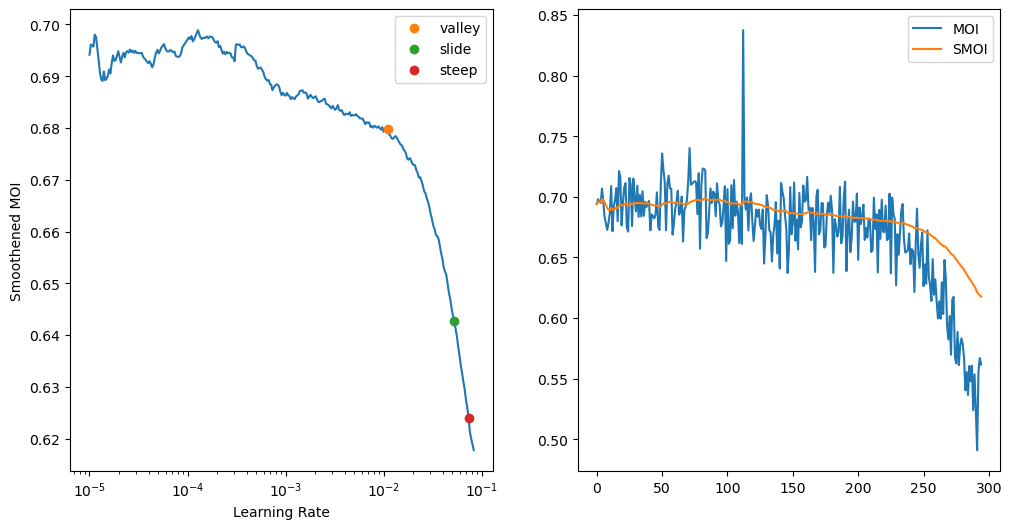

In [ ]:
learner.xrl_find(num_it=300, suggest_funcs=(valley, slide, steep))

In [ ]:
# learner.fit_one_cycle(1, lr_max=0.014454)
# learner.fit_one_cycle(15, lr_max=0.014454)
# learner.fit_one_cycle(1, lr_max=0.0611)
# learner.fit_one_cycle(3, lr_max=0.0611)
# learner.fit_one_cycle(1, lr_max=0.01239)
# learner.fit_one_cycle(3, lr_max=0.01239)
learner.fit_one_cycle(1, lr_max=0.010964)
learner.fit_one_cycle(3, lr_max=0.010964)

0 True 1.3046 NA NA NA
0 False 0.9848 0.774 0.7596 0.7612


0 True 1.2438 NA NA NA
0 False 0.9702 0.7635 0.7474 0.7637
1 True 1.2317 NA NA NA
1 False 0.9498 0.7723 0.7571 0.7631
2 True 1.2137 NA NA NA
2 False 0.9418 0.7711 0.756 0.764


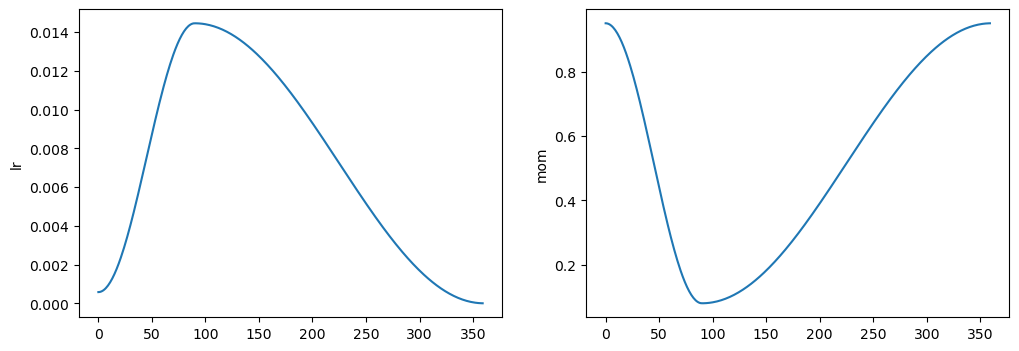

In [ ]:
learner.track_results.plot_sched()

In [ ]:
# len(learner.cbs[1].grads_full['token_factors.weight'])
# learner.cbs
# learner.track_results
# learner.opt.hypers[-1]

In [ ]:
learner = learner.load(fname, device=default_device())

In [ ]:
learner.validate()

0 False 1.0591 0.7812 0.7686 0.76


In [ ]:
learner.cbs[-1].best = 0.7686

In [ ]:
# emb_szs = get_emb_sz(dls.train_ds, {})

#### Plots

**Plotting losses and metrics:**

In [ ]:
#| eval: false
fig, axes = plt.subplots(2, 2, figsize=(15,8))
loss = L(loss_logger).map(torch.Tensor.item)
val_loss = L(metric_logger).itemgot(0)
val_acc = L(metric_logger).itemgot(-1)
val_ndcg = L(metric_logger).itemgot(2)

# axes[0,0].scatter(range(len(loss)), loss)
axes[0,0].plot(range(len(loss)), loss)
axes[0,0].set_xlabel('batches*epochs')
axes[0,0].set_ylabel('train loss')

axes[0,1].plot(val_loss)
axes[0,1].set_xlabel('epochs')
axes[0,1].set_ylabel('val loss')

axes[1, 0].plot(val_acc)
axes[1,0].set_xlabel('epochs')
axes[1,0].set_ylabel('val accuracy')

axes[1,1].plot(val_ndcg)
axes[1,1].set_xlabel('epochs')
axes[1,1].set_ylabel('val ndcg@6 (candidate 16)')

plt.show()

**Plotting Statistics of the Model Parameters**

In [ ]:
#| eval: false
fig, axes = plt.subplots(2,2, figsize=(15,8), sharex=True)
for (k,v), ax in zip(grad_logger.items(), axes.flatten()):
    mean_grads = L(v).map(compose(torch.Tensor.square, torch.Tensor.mean, torch.Tensor.sqrt, torch.Tensor.item))
    # sparsity = L(v).map(sparsity)
    ax.plot(mean_grads, color='r', label='mean')
    ax.set_ylabel(k)
    # ax_a = ax.twinx()
    # ax_a.plot(sparsity, color='b', label='sparsity')
    ax.legend(loc='best')
    # ax_a.legend(loc='best')
fig.suptitle('RMS of the Gradients of Model Parameters')
plt.show()

In [ ]:
def sparsity(t): 
    return 1 - (torch.count_nonzero(t)/t.numel()).item()

In [ ]:
#| eval: false
fig, axes = plt.subplots(2,2, figsize=(15,8), sharex=True)
for (k,v), ax in zip(grad_logger.items(), axes.flatten()):
    sp = L(v).map(sparsity)
    ax.scatter(range(len(sp)), sp, color='r', label='sparsity')
    ax.set_ylabel(k)
    # ax_a = ax.twinx()
    # ax_a.plot(sparsity, color='b', label='sparsity')
    ax.legend(loc='best')
    # ax_a.legend(loc='best')
fig.suptitle('Sparsity of the Model Parameters')
plt.show()

#### Analysis to find out what the L2R model is upto:

In [ ]:
dataset = to_device(learner.dls.train.dataset)

In [ ]:
%%time
_ndcg_at_k = ndcg_at_k(dataset, learner.model, k=15)

CPU times: user 5.73 s, sys: 0 ns, total: 5.73 s
Wall time: 5.86 s


In [ ]:
ic(_ndcg_at_k.shape, _ndcg_at_k.min(), _ndcg_at_k.mean(), _ndcg_at_k.max(), _ndcg_at_k.median(), _ndcg_at_k.std());

ic| _ndcg_at_k.shape: torch.Size([1, 8922])
    _ndcg_at_k.min(): tensor(4.0372e-19, device='cuda:0')
    _ndcg_at_k.mean(): tensor(0.3494, device='cuda:0')
    _ndcg_at_k.max(): tensor(0.9934, device='cuda:0')
    _ndcg_at_k.median(): tensor(0.3283, device='cuda:0')
    _ndcg_at_k.std(): tensor(0.2672, device='cuda:0')


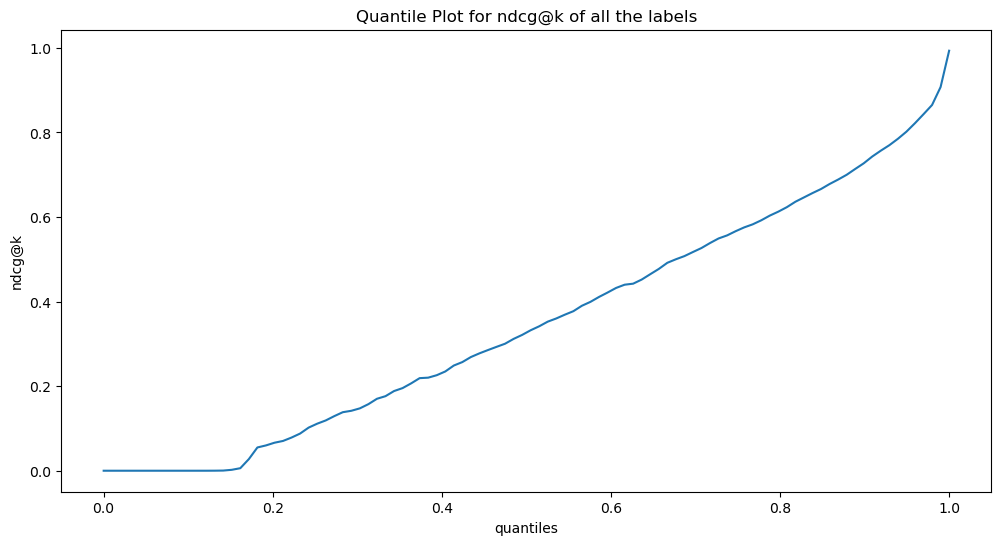

In [ ]:
qnts = torch.linspace(0, 1, 100)
plt.plot(qnts, _ndcg_at_k.cpu().quantile(qnts, dim=-1).view(-1));
plt.xlabel('quantiles')
plt.ylabel('ndcg@k')
plt.title('Quantile Plot for ndcg@k of all the labels')
plt.show()

In [ ]:
%%time
acc = accuracy(dataset, learner.model)

CPU times: user 276 ms, sys: 0 ns, total: 276 ms
Wall time: 286 ms


In [ ]:
ic(acc.shape, acc.min(), acc.mean(), acc.max(), acc.median(), acc.std());

ic| acc.shape: torch.Size([1, 104])
    acc.min(): tensor(0.6281, device='cuda:0')
    acc.mean(): tensor(0.7566, device='cuda:0')
    acc.max(): tensor(0.7964, device='cuda:0')
    acc.median(): tensor(0.7626, device='cuda:0')
    acc.std(): tensor(0.0296, device='cuda:0')


Let's pick some random labels and see the rankings produced by the model:

In [ ]:
df_res, df_ndcg= learner.show_results(k=15)

In [ ]:
df_ndcg[df_ndcg.ndcg_at_k >= 0.5]

,labels,ndcg_at_k
5,5644,0.505686
6,5102,0.608648
8,1804,0.594066
11,2355,0.581916
22,8161,0.500200
28,2877,0.557069
30,129,0.706364
33,1245,0.733052
35,16,0.618285
38,1208,0.518697


In [ ]:
df_ndcg.head(10)

,labels,ndcg_at_k
0,8526,4.967139e-16
1,7962,4.525589e-15
2,3987,5.901048e-01
3,6165,2.050589e-13
4,6168,3.538292e-10
5,2640,3.429065e-13
6,862,1.326269e-14
7,2750,2.974324e-14
8,7083,1.927360e-12
9,7382,3.322057e-13


In [ ]:
df_res

label     4565                                                  6569          \
key2       tok     lbl     rank score      preds model_rank      tok     lbl   
toks                                                                           
0      51577.0  4565.0  53188.0   1.0 -41.782745    54696.0  51577.0  6569.0   
1      52360.0  4565.0  36926.0   5.0 -36.372681    46839.0  52360.0  6569.0   
2      37101.0  4565.0  23703.0  10.0 -42.323380    55161.0  37101.0  6569.0   
3      37705.0  4565.0  24090.0  10.0 -24.040859    17313.0  37705.0  6569.0   
4      14257.0  4565.0   4641.0  28.0 -27.471664    24536.0  14257.0  6569.0   
...        ...     ...      ...   ...        ...        ...      ...     ...   
57347   4537.0  4565.0  16797.0  14.0 -17.453377     7259.0   4537.0  6569.0   
57348   1622.0  4565.0   1927.0  37.0 -14.181708     4227.0   1622.0  6569.0   
57349  16373.0  4565.0   5797.0  25.0 -19.083836     9199.0  16373.0  6569.0   
57350  43863.0  4565.0  31410.0   7.0 -39.971527    52866.0  43863.0  6569.0   
57351  11619.0  4565.0   5573.0  26.0 -26.214912    21706.0  11619.0  6569.0   

label                 ...     1047                                 1349  \
key2      rank score  ...     rank score      preds model_rank      tok   
toks                  ...                                                 
0      51079.0   2.0  ...  50834.0   2.0 -45.150726    55395.0  51577.0   
1      35079.0   6.0  ...  21593.0  11.0 -37.832306    46060.0  52360.0   
2      40328.0   4.0  ...  32080.0   7.0 -31.006001    31124.0  37101.0   
3      40714.0   4.0  ...  32466.0   7.0 -29.984770    28882.0  37705.0   
4      13676.0  16.0  ...  12842.0  17.0 -24.753557    18343.0  14257.0   
...        ...   ...  ...      ...   ...        ...        ...      ...   
57347   3001.0  32.0  ...   3601.0  30.0 -15.355591     2176.0   4537.0   
57348  33860.0   6.0  ...    950.0  45.0  -9.783297      112.0   1622.0   
57349  15122.0  15.0  ...  16773.0  14.0 -17.529833     5061.0  16373.0   
57350  25107.0   9.0  ...  40880.0   4.0 -26.384148    21487.0  43863.0   
57351  14697.0  15.0  ...  16236.0  14.0 -22.856853    14855.0  11619.0   

label                                               
key2      lbl     rank score      preds model_rank  
toks                                                
0      1349.0  53188.0   1.0 -32.015938    34146.0  
1      1349.0  36928.0   5.0 -38.207287    48127.0  
2      1349.0  23697.0  10.0 -38.562450    48761.0  
3      1349.0  24084.0  10.0 -35.929695    43524.0  
4      1349.0   4612.0  28.0 -25.678783    19302.0  
...       ...      ...   ...        ...        ...  
57347  1349.0  16785.0  14.0 -18.952923     8060.0  
57348  1349.0   1878.0  37.0 -18.222450     7188.0  
57349  1349.0   5781.0  25.0 -29.995731    29059.0  
57350  1349.0  31405.0   7.0 -34.167110    39351.0  
57351  1349.0   5553.0  26.0 -25.605606    19152.0  

[57352 rows x 600 columns]

In [ ]:
df_lbl = df_res.loc[:, 934]
df_lbl

key2,tok,lbl,rank,score,preds,model_rank
toks,,,,,,
0,51577.0,934.0,53188.0,1.0,-19.667917,5888.0
1,52360.0,934.0,34324.0,6.0,-31.594564,32015.0
2,37101.0,934.0,31239.0,7.0,-39.322235,50443.0
3,37705.0,934.0,31626.0,7.0,-41.059654,52976.0
4,14257.0,934.0,12569.0,17.0,-24.408052,15270.0
...,...,...,...,...,...,...
57347,4537.0,934.0,3247.0,31.0,-17.787853,3021.0
57348,1622.0,934.0,9534.0,20.0,-17.016525,2166.0
57349,16373.0,934.0,14253.0,15.0,-25.219761,16950.0


In [ ]:
df2 = df_lbl.sort_values(by='rank').head(15)
df2

key2,tok,lbl,rank,score,preds,model_rank
toks,,,,,,
38712,9429.0,934.0,0.0,101.0,2.399450,1.0
30106,31007.0,934.0,1.0,100.0,-5.644907,17.0
50302,5150.0,934.0,2.0,100.0,-0.324139,3.0
20514,42988.0,934.0,3.0,100.0,-5.003191,13.0
16688,48423.0,934.0,4.0,100.0,5.765238,0.0
39796,21173.0,934.0,5.0,100.0,-10.666720,136.0
26300,24115.0,934.0,6.0,99.0,-7.009228,26.0
29622,24101.0,934.0,7.0,97.0,-11.829512,220.0
29563,52417.0,934.0,8.0,96.0,-6.944853,25.0


In [ ]:
# idcg_at_k = pow(2, df2['score']) * (1 / np.log2(df2['rank']+2)  )
# idcg_at_k

# df3 = df_lbl.sort_values(by='model_rank').head(10)
# df3

# dcg_at_k = pow(2, df3['score'])  *(1/np.log2(df3['model_rank']+2))
# dcg_at_k

# dcg_at_k.sum()/idcg_at_k.sum()